<a href="https://colab.research.google.com/github/armiro/Advanced-Deep-Learning-with-Keras-in-Python/blob/master/dental_caries_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras.backend as K
print('TensorFlow version is', tf.__version__)

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Add, Flatten, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Concatenate, Activation
from tensorflow.keras import Model, optimizers

import os, glob, numpy as np, time, shutil, pickle, matplotlib.pyplot as plt, cv2, zipfile

next_init_epoch = 0

# see the provided CPU/GPU devices
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

num healthy images: 380
num carious images: 187
num total dataset images: 567
num total dataset labels: 567
dataset shape: (567, 400, 400, 1)
random image from the dataset:


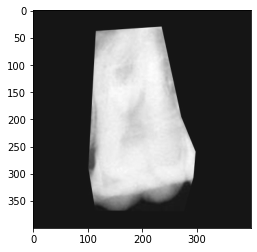

In [0]:
# image data preparation
path = './drive/My Drive/Datasets/panoramic_dataset/healthy/**.jpg'
neg_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  # img = np.expand_dims(a=img, axis=-1)
  neg_images.append(img)

neg_images = np.array(neg_images)
print('num healthy images:', len(neg_images))

path = './drive/My Drive/Datasets/panoramic_dataset/caries/**.jpg'
pos_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  # img = np.expand_dims(a=img, axis=-1)
  pos_images.append(img)

pos_images = np.array(pos_images)
print('num carious images:', len(pos_images))

neg_labels = [0 for _ in range(len(neg_images))]
pos_labels = [1 for _ in range(len(pos_images))]

X = np.concatenate((pos_images, neg_images))
y = np.array(pos_labels + neg_labels)

# resize images if pre-trained model is trained on specific input shape
X = np.array([cv2.resize(image, dsize=(400, 400), interpolation=cv2.INTER_CUBIC) for image in X])
X = np.array([np.expand_dims(a=image, axis=-1) for image in X])

# do the rescaling
X = np.array([X[idx] / 255. for idx in range(len(X))])

print('num total dataset images:', len(X))
print('num total dataset labels:', len(y))
print('dataset shape:', X.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

print('random image from the dataset:')
rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.show()

In [0]:
# dealing with data imbalance problem: resampling
# note: resampling must be done after train/test split, because doing that before it
# may result in having same sample both in training and test sets which causes overfitting!
from sklearn.utils import resample

pos_upsampled_train = resample(X_train[y_train == 1], n_samples=len(X_train[y_train == 0]), 
                               replace=True, random_state=20)
pos_upsampled_test = resample(X_test[y_test == 1], n_samples=len(X_test[y_test == 0]),
                              replace=True, random_state=20)

X_train_resampled = np.concatenate((X_train[y_train == 0], pos_upsampled_train))
X_test_resampled = np.concatenate((X_test[y_test == 0], pos_upsampled_test))
y_train_resampled = np.concatenate(([0 for _ in range(len(X_train[y_train == 0]))], 
                                    [1 for _ in range(len(X_train[y_train == 0]))]))
y_test_resampled = np.concatenate(([0 for _ in range(len(X_test[y_test == 0]))], 
                                   [1 for _ in range(len(X_test[y_test == 0]))]))

print('num resampled training-set samples:', len(X_train_resampled))
print('num resampled test-set samples:', len(X_test_resampled))

num resampled training-set samples: 604
num resampled test-set samples: 156


In [0]:
aug = ImageDataGenerator(rescale=None, rotation_range=90, zoom_range=[0.75, 1.25], 
                         width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.15, horizontal_flip=True, 
                         vertical_flip=True, zca_whitening=False, fill_mode='nearest')

test_aug = ImageDataGenerator(rescale=None)

In [0]:
def create_model():
  image_in = Input(shape=X_train[0].shape, name='input')
  x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='conv1')(image_in)
  x0 = BatchNormalization(momentum=0.9, name='bn1')(x)
  x1 = MaxPooling2D(pool_size=2, strides=2, padding='same', name='mp1')(x0)
  x2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='conv2')(x1)
  x2 = BatchNormalization(momentum=0.9, name='bn2')(x2)
  x3 = MaxPooling2D(pool_size=2, strides=2, padding='same', name='mp2')(x2)
  x4 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='conv3')(x3)
  x4 = BatchNormalization(momentum=0.9, name='bn3')(x4)
  x5 = MaxPooling2D(pool_size=2, strides=2, padding='same', name='mp3')(x4)
  x6 = Flatten(name='flatten')(x5)
  x7 = Dense(units=20, activation='relu', name='fc1')(x6)
  x8 = Dense(units=20, activation='relu', name='fc2')(x7)
  x9 = Dense(units=10, activation='relu', name='fc3')(x8)
  x10 = Dense(units=1, activation='sigmoid', name='output')(x9)
  return Model(inputs=image_in, outputs=x10, name='binary_classifier')

classifier = create_model()
custom_opt = optimizers.Adam(learning_rate=0.0001)
classifier.compile(optimizer=custom_opt, loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()
print('Num network layers:', len(classifier.layers))

In [0]:
def get_last_weights(folder):
  """
  find last saved weights file and its epoch number
  :param folder: string
  :return: int, string
  """
  num_epochs = list()
  for weights_file in glob.glob(folder + '/**.hdf5'):
    num_epoch = int(weights_file[weights_file.find('=')+1:weights_file.find('_')])
    num_epochs.append((num_epoch, weights_file))

  last_epoch = max(num_epochs)[0]
  print('last saved epoch:', last_epoch)
  last_file = max(num_epochs)[1]
  print('last saved file:', last_file)
  return last_epoch, last_file


def delete_other_weights(folder, last_file):
  """
  delete all weights files saved before, except the last one which is the best
  :param folder: string
  :param last_file: string
  :return None
  """

  for weights_file in os.listdir(folder):
    if weights_file.endswith('.hdf5'):
      file_path = os.path.join(folder, weights_file)
      if file_path != last_file:
        try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
          elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
        except Exception as e:
          print('failed to delete %s. because of: %s' % (file_path, e))
      else:
        pass
  print('deleted all weights files saved before, except the last one.')


def save_obj(obj, name):
  with open('/'+ name + '.pkl', 'wb+') as f:
    pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
  with open('/' + name + '.pkl', 'rb') as f:
    return pickle.load(f)

In [0]:
# load the last saved weigths file as the model's weights and delete others
# run it ONLY if Google Colab stopped in the middle of model training
weights_folder = '/content/drive/My Drive/model'
next_init_epoch, last_epoch_weights_file = get_last_weights(weights_folder)
classifier.load_weights(last_epoch_weights_file)
delete_other_weights(folder=weights_folder, last_file=last_epoch_weights_file)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

file_path = '/content/drive/My Drive/model/eps={epoch:03d}_valAcc={val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

cb_list = [checkpoint]

In [0]:
training = classifier.fit(x=aug.flow(x=X_train_resampled, y=y_train_resampled, batch_size=32), 
                          callbacks=cb_list, initial_epoch=next_init_epoch, verbose=1, epochs=500, 
                          validation_data=test_aug.flow(x=X_test_resampled, y=y_test_resampled),
                          steps_per_epoch=20, validation_steps=5)

path = '/content/drive/My Drive/model/'
# save_obj(obj=training.history, name=path+'training_history')

In [0]:
# path = '/content/drive/My Drive/model/'
# training_his = load_obj(name=path+'training_history')
fig = plt.figure()
# plt.plot(training.history['loss'], color='r', label='training_loss')
# plt.plot(training_his['loss'], color='r', label='training_loss')
plt.plot(training.history['val_loss'], color='g', label='validation_loss')
# plt.plot(training_his['val_loss'], color='g', label='val_loss')
plt.legend()
plt.show()
fig.savefig(path+'training_history_1.png')

In [0]:
# save the final best weights and delete others (after training is finished)
weights_folder = '/content/drive/My Drive/model'
_, best_weights = get_last_weights(weights_folder)
acc = float(best_weights[best_weights.rfind('=')+1:best_weights.rfind('.')])
print('best validation accuracy:', acc)
classifier.load_weights(best_weights)
delete_other_weights(folder=weights_folder, last_file=best_weights)

last saved epoch: 223
last saved file: /content/drive/My Drive/model/eps=223_valAcc=0.8462.hdf5
best validation accuracy: 0.8462
deleted all weights files saved before, except the last one.


In [0]:
from sklearn.metrics import confusion_matrix

y_pred = classifier.predict(generator=test_aug.flow(x=X_test_resampled, batch_size=1, shuffle=False),
                                      steps=len(X_test_resampled))

print('num images:', len(y_test_resampled))
print(y_test_resampled)

y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)), decimals=2)[0]
print(y_pred)
y_pred_rnd = np.round(np.reshape(a=y_pred, newshape=(1, -1)))[0]
# print(y_pred_rnd)
cm = confusion_matrix(y_true=y_test_resampled, y_pred=y_pred_rnd)
print(cm)
print('acc:', (cm[0][0] + cm[1][1])/np.sum(cm))

Instructions for updating:
Please use Model.predict, which supports generators.
num images: 156
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[0.33 0.13 0.14 0.43 0.66 0.43 0.13 0.69 0.49 0.78 0.47 0.08 0.66 0.3
 0.28 0.29 0.62 0.12 0.61 0.65 0.58 0.36 0.25 0.52 0.49 0.05 0.24 0.04
 0.54 0.44 0.1  0.93 0.4  0.42 0.27 0.46 0.4  0.64 0.54 0.45 0.22 0.24
 0.5  0.14 0.09 0.11 0.34 0.52 0.05 0.67 0.79 0.26 0.49 0.37 0.21 0.12
 0.11 0.49 0.09 0.83 0.03 0.06 0.73 0.06 0.44 0.4  0.32 0.21 0.4  0.28
 0.02 0.36 0.58 0.71 0.44 0.62 0.46 0.69 0.72 0.66 0.63 0.88 0.37 0.66
 0.53 0.79 0.59 0.87 0.42 0.67 0.55 0.61 0.66 0.66 0.25 0.85 0.85 0.42
 0.67 0.63 0.66 0.79 0.59 0.5  0.72 0.89 0.59 0.79 0.25 0.89 0.55 0.89
 0.63 0.59 0.71 0.7

In [0]:
# save the model architecture and dataset as json and zip/npy files
model_json = classifier.to_json()
with open("./drive/My Drive/model/model.json", "w") as json_file:
    json_file.write(model_json)

shutil.make_archive(base_name='./drive/My Drive/dataset', format='zip', 
                    base_dir='./drive/My Drive/Datasets/panoramic_dataset/')
# np.save(file='./drive/My Drive/dataset.npy', arr='./drive/My Drive/dataset.zip')

In [0]:
#####################################

In [0]:
# "vis" library used for saliency map, only works with scipy<=1.3.0
!pip install vis
!pip show vis
# !pip show pillow
!pip install scipy==1.1.0
!pip show scipy

probability: [[0.3608321]]
probability: [[0.47909716]]
probability: [[0.06575596]]
probability: [[0.9998547]]


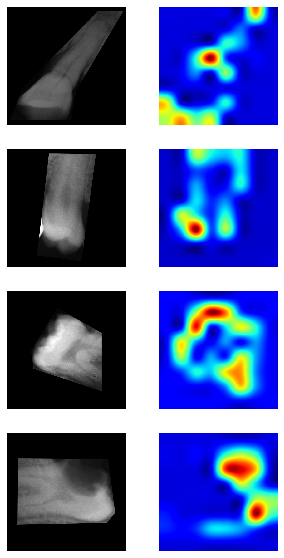

In [0]:
# draw the saliency map of the network (grad-CAM)
from vis.visualization import visualize_cam
# from vis.utils import utils
# from keras import activations
# import warnings
# warnings.filterwarnings('ignore')

img_indices = np.random.randint(low=0, high=len(X_train), size=4)

plt.rcParams["figure.figsize"] = (5,10)
f, ax = plt.subplots(len(img_indices), 2)

for i, img_idx in enumerate(img_indices):
  this_img = np.array(X_train[img_idx] / 255.)
  ax[i][0].imshow(this_img.squeeze(), cmap='gray', vmin=0, vmax=1)
  ax[i][0].axis('off')
  saliency_map = visualize_cam(net, layer_idx=-1, filter_indices=None, seed_input=this_img, 
                               backprop_modifier=None)       
  ax[i][1].imshow(saliency_map, cmap='jet')
  ax[i][1].axis('off')
  print('probability:', net.predict(np.expand_dims(this_img, axis=0)))


In [0]:
# ONLY if visualize_saliency is to be imported from vis.visualization
!pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

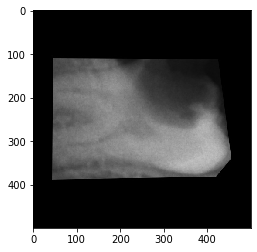

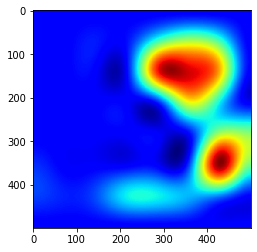

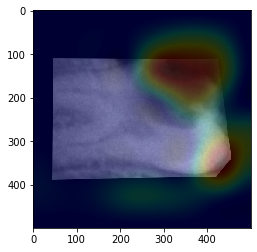

[[0.9998547]]
1


In [0]:
from vis.visualization import visualize_cam, overlay
from vis.utils import utils
# from vis.visualization import visualize_saliency
import matplotlib.cm as cm

IMG_IDX = 98
test_img = np.array(X_train[IMG_IDX] / 255.)
layer_idx = utils.find_layer_idx(model=net, layer_name='output')

plt.imshow(test_img.squeeze(), cmap='gray', vmin=0, vmax=1)
plt.show()

grads = visualize_cam(model=net, layer_idx=layer_idx, filter_indices=None, seed_input=test_img,
                      penultimate_layer_idx=None, backprop_modifier=None, grad_modifier=None)
# s_map = visualize_saliency(net, -1, None, test_img, grad_modifier='invert')
plt.imshow(grads, cmap='jet')
plt.show()

jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
# print(jet_heatmap.shape)
ch_test_img = np.concatenate((X_train[IMG_IDX], X_train[IMG_IDX], X_train[IMG_IDX]), axis=-1)
# print(ch_test_img.shape)
plt.imshow(overlay(jet_heatmap, ch_test_img, alpha=0.2))
plt.show()

print(net.predict(np.expand_dims(test_img, axis=0)))
print(y_train[IMG_IDX])